In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Image shape: (4800, 2656)
Rows found: 1
Raw yolo string: (0.142696, 0.647083, 0.081325, 0.0525)
→ (x1=271, y1=2979, x2=487, y2=3231) in image size (2656,4800)


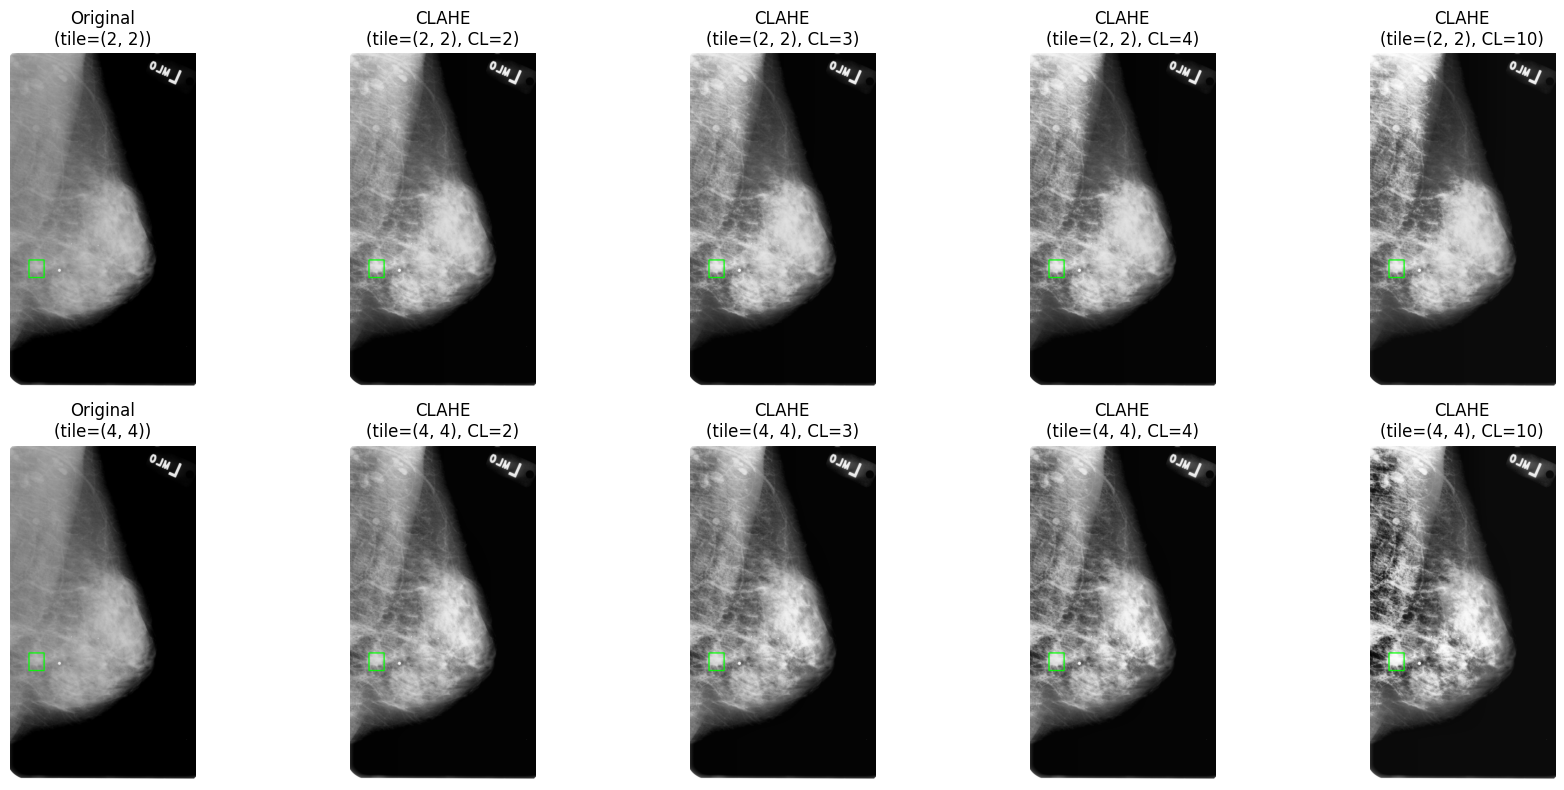

In [18]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os

# === Paths ===
csv_path = "/content/drive/MyDrive/colab_scripts/repository/datasets/CBIS-DDSM/csv/train_plus_test.csv"
img_path = "/content/drive/MyDrive/colab_scripts/repository/datasets/CBIS-DDSM/NEW/IMAGES/P_00001_LEFT_MLO.jpg"

# === Load image (grayscale) ===
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
h, w = img.shape
print("Image shape:", (h, w))

# Median filter
img = cv2.medianBlur(img, 3)

# === Load CSV ===
df = pd.read_csv(csv_path)

# Extract image name
img_name = 'P_00001_LEFT_MLO'

# Filter rows for this image
rows = df[df["new name"] == img_name]
print("Rows found:", len(rows))

# Parse YOLO bboxes
bboxes = []
for yolo_str in rows["yolo_bbox"]:
    print("Raw yolo string:", yolo_str)

    yolo_str = str(yolo_str).strip("() ")
    values = [float(v) for v in yolo_str.split(",")]

    if len(values) == 5:
        _, x_c, y_c, bw, bh = values  # has class id
    elif len(values) == 4:
        x_c, y_c, bw, bh = values
    else:
        raise ValueError(f"Unexpected bbox format: {values}")

    # convert normalized → pixels
    x_c, y_c, bw, bh = x_c * w, y_c * h, bw * w, bh * h
    x1, y1 = int(x_c - bw/2), int(y_c - bh/2)
    x2, y2 = int(x_c + bw/2), int(y_c + bh/2)

    print(f"→ (x1={x1}, y1={y1}, x2={x2}, y2={y2}) in image size ({w},{h})")
    bboxes.append((x1, y1, x2, y2))


# === CLAHE parameter sets ===
clip_limits = [2, 3, 4,10]
tile_sizes = [(2,2), (4,4)]

# === Plot images with boxes ===
fig, axes = plt.subplots(len(tile_sizes), len(clip_limits)+1, figsize=(18,8))

for row, tile in enumerate(tile_sizes):
    # Original
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    for x1, y1, x2, y2 in bboxes:
        cv2.rectangle(img_rgb, (x1,y1), (x2,y2), (0,255,0), 15)

    axes[row,0].imshow(img_rgb)
    axes[row,0].set_title(f"Original\n(tile={tile})")
    axes[row,0].axis("off")

    for col, cl in enumerate(clip_limits, start=1):
        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=cl, tileGridSize=tile)
        clahe_img = clahe.apply(img)

        clahe_rgb = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2RGB)

        # Draw bboxes
        for x1, y1, x2, y2 in bboxes:
            cv2.rectangle(clahe_rgb, (x1,y1), (x2,y2), (0,255,0), 15)

        axes[row,col].imshow(clahe_rgb)
        axes[row,col].set_title(f"CLAHE\n(tile={tile}, CL={cl})")
        axes[row,col].axis("off")

plt.tight_layout()
plt.show()

In [16]:
# Save the figure
out_path = "/content/clahe_bbox_grid.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")

# Download to your computer
from google.colab import files
files.download(out_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
import cv2
import os
import glob


input_folder = "/content/drive/MyDrive/MIAS/Images"        # folder where MIAS images are stored
output_folder = "/content/drive/MyDrive/MIAS/CLAHE" # folder where processed images will be saved

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# --- Parameters for CLAHE ---
tile_grid_size = (4,4)
clip_limit = 25          # the best parameters based on visualizations

# --- Process all images ---
for img_path in glob.glob(os.path.join(input_folder, "*.jpg")):
    # Read image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue  # skip if image not loaded

    # Step 1: Apply Median Filter (kernel size 3x3 or 5x5)
    median_img = cv2.medianBlur(img, 3)

    # Step 2: Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    clahe_img = clahe.apply(median_img)

    # Step 3: Save result
    filename = os.path.basename(img_path)  # keep original filename
    save_path = os.path.join(output_folder, filename)
    cv2.imwrite(save_path, clahe_img)

print("✅ All images processed and saved in:", output_folder)